In [1]:
import argparse
import numpy as np
import pandas as pd
import pickle
import ast, os, sys
import neuroglancer
import matplotlib
import cv2
from skimage import img_as_ubyte
from matplotlib import pyplot as plt

In [2]:
PATH = '/home/eddyod/programming/pipeline_utility'
sys.path.append(PATH)
from utilities.contour_utilities import get_contours_from_annotations, add_structure_to_neuroglancer
neuroglancer.set_server_bind_address(bind_port='33645')

Connecting dklab@192.168.1.12:3306


In [3]:
DIR = '/net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes'
#contourpath = os.path.join(DIR, 'MD589_full_filled.npy')
contourpath = '/net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes/atlasV8/volume_test.npy'
structure = 'SC'
#contourpath = os.path.join(DIR, 'atlasV7', 'score_volumes', 'Sp5O_R.npy')
#contourpath = os.path.join(DIR, 'atlasV7', 'score_volumes', '{}.npy'.format(structure))
contour = np.load(contourpath)

In [4]:
contour.dtype, contour.shape, np.median(contour), np.mean(contour), np.amax(contour)

(dtype('uint8'), (268, 3000, 5000), 0.0, 0.05442950422885572, 23)

In [ ]:
colors = {'Sp5O_R':23, 'SC':18, 'IC':11}
color = colors[structure]
volume_nonzero_indices = contour > 0
contour[volume_nonzero_indices] = color
vm = contour.astype(np.uint8)
vm.shape, vm.dtype

In [5]:
vm = np.swapaxes(contour,0,2)
vm.shape, vm.dtype

((5000, 3000, 268), dtype('uint8'))

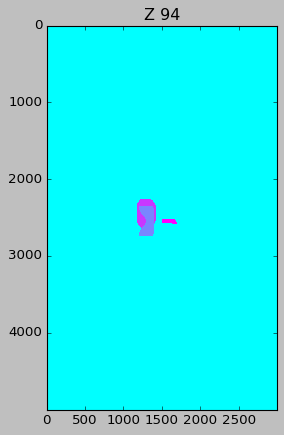

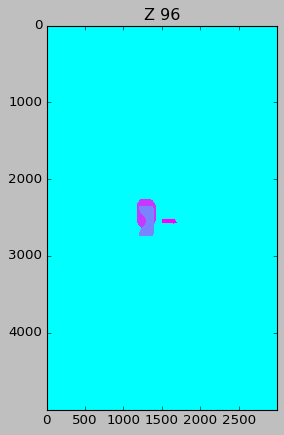

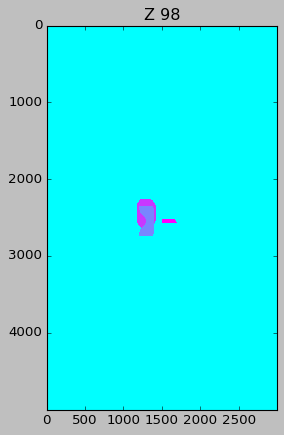

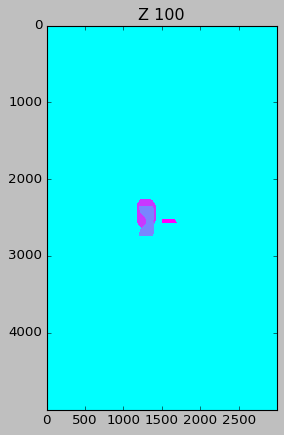

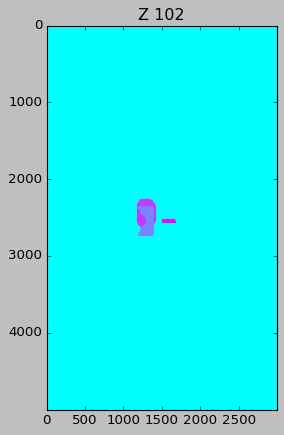

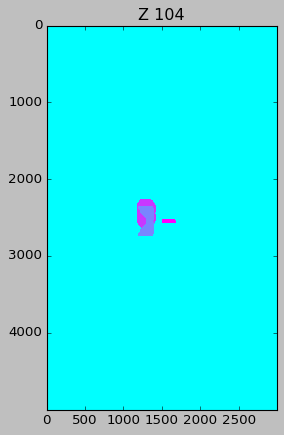

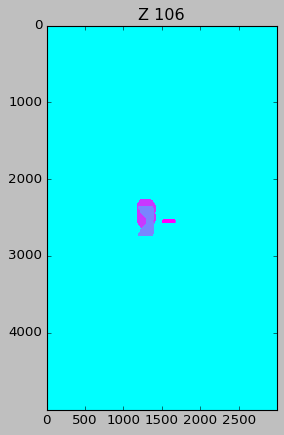

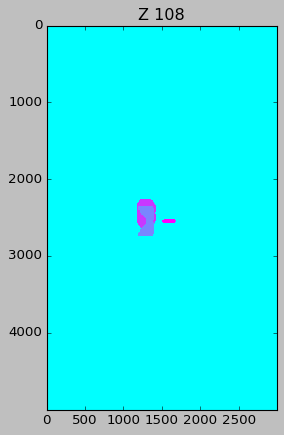

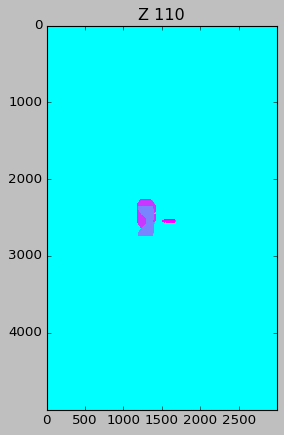

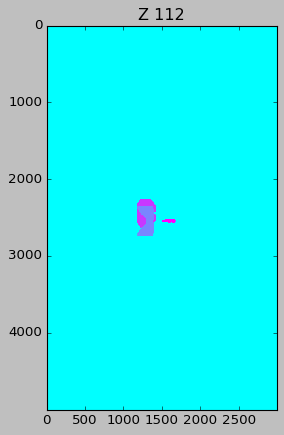

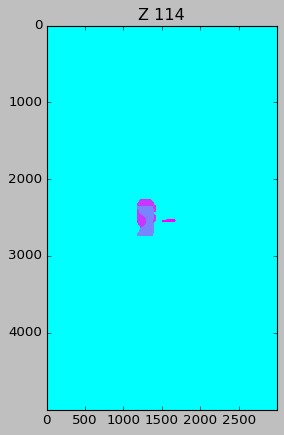

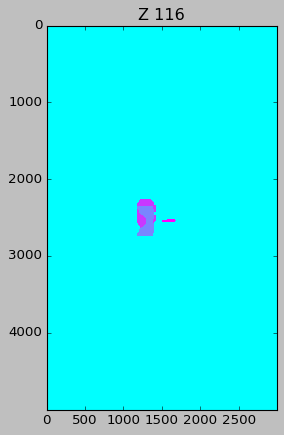

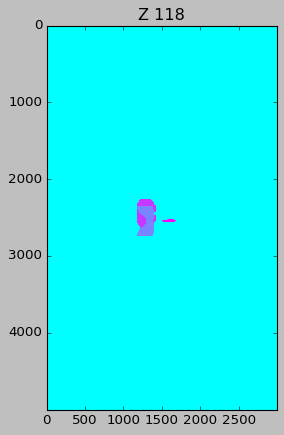

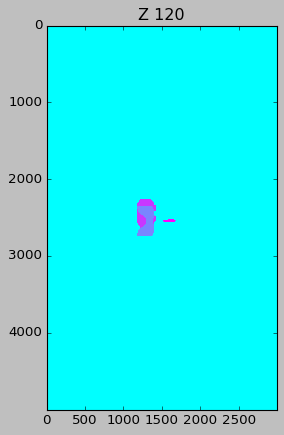

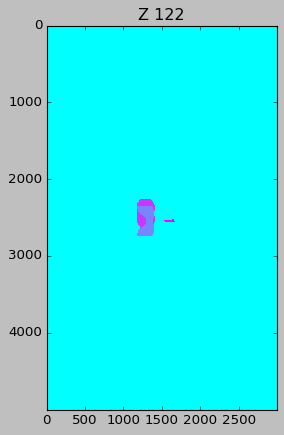

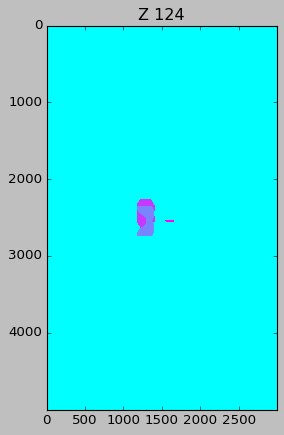

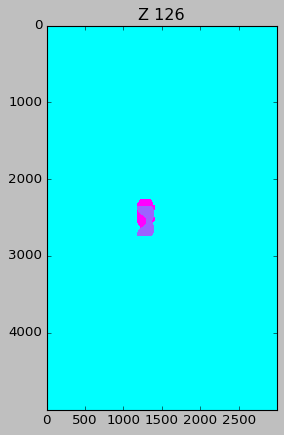

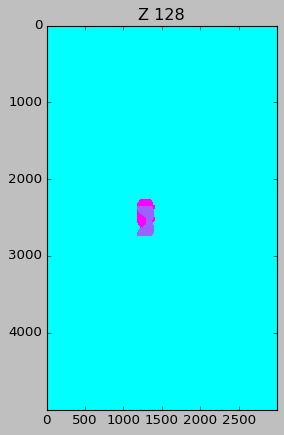

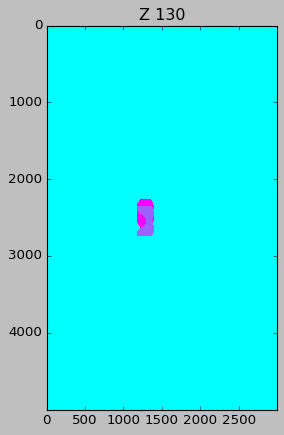

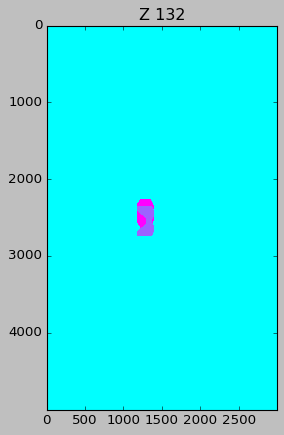

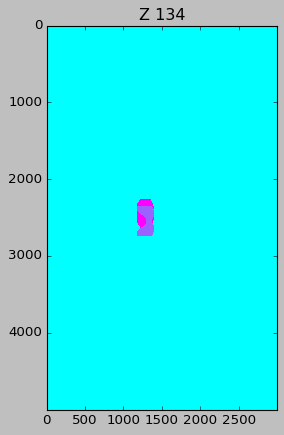

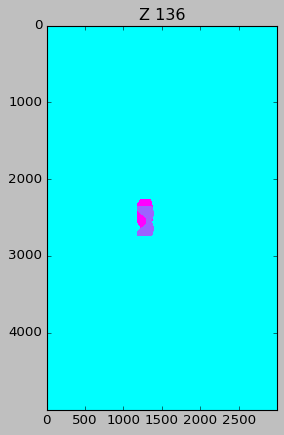

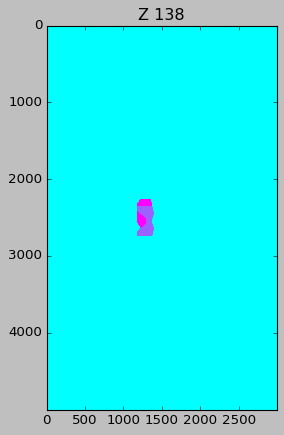

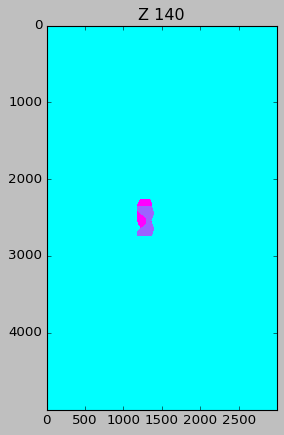

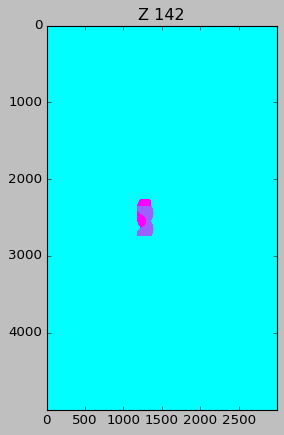

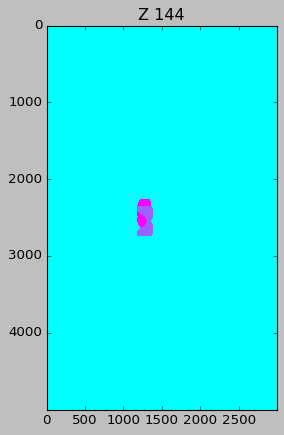

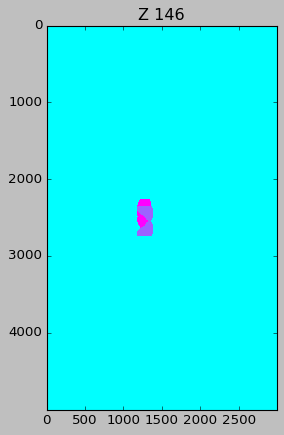

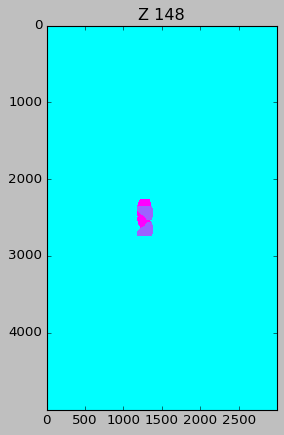

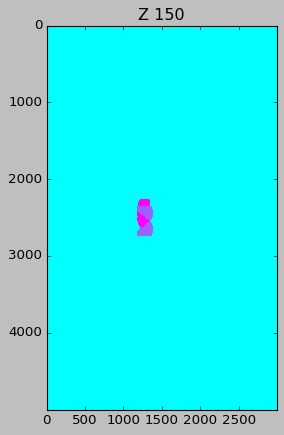

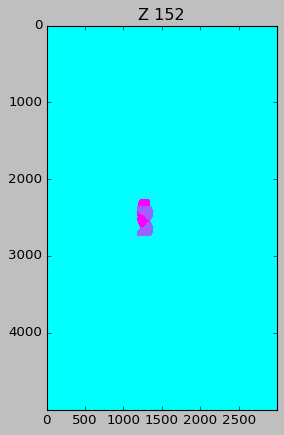

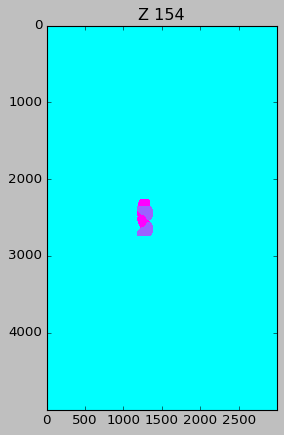

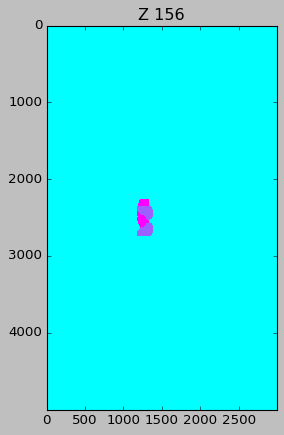

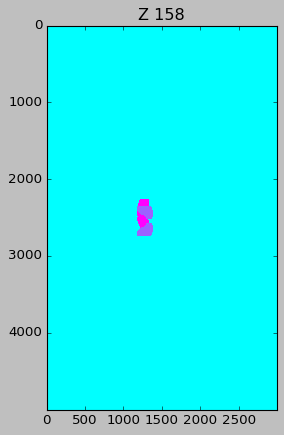

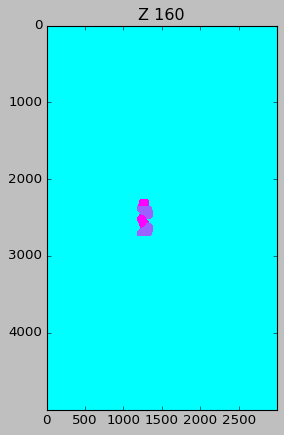

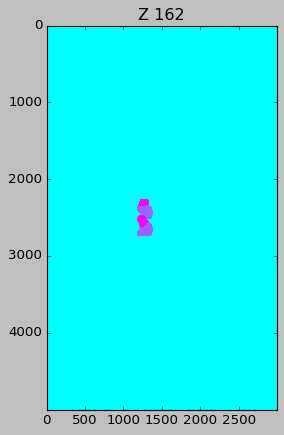

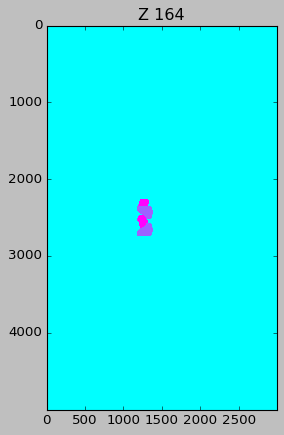

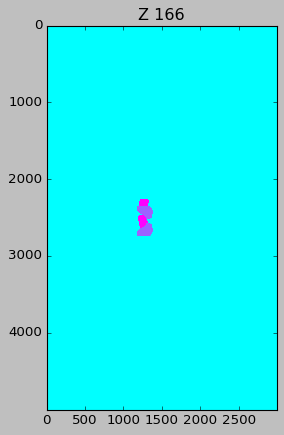

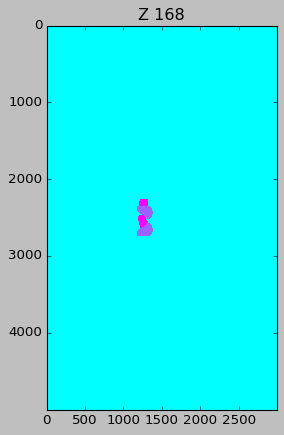

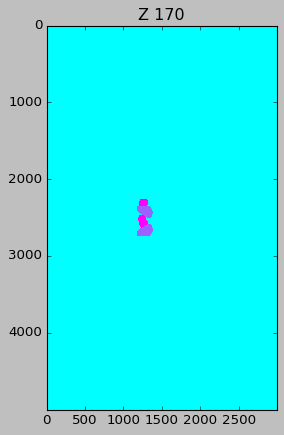

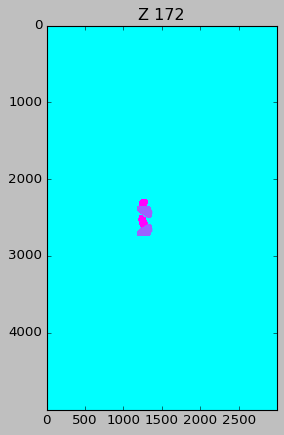

In [6]:
arr = vm
limit = 40
start = (arr.shape[2] // 2) - limit
end = start + limit * 2
nrows = end - start
ncols = 1
plt.style.use('classic')
for i in range(start, end, 2):
    plt.title('Z {}'.format(i))
    plt.imshow(arr[:,:,i], cmap="cool")
    plt.show()

In [7]:
dimensions = neuroglancer.CoordinateSpace(
    names=['x', 'y', 'z'],
    units='nm',
    scales=[460,460,460])
animal = 'DK52'
layer_source = 'precomputed://https://activebrainatlas.ucsd.edu/data/{}/neuroglancer_data/C1'.format(animal)

viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    s.dimensions = dimensions
    s.layout = '4panel'
    s.layers[animal] = neuroglancer.ImageLayer(source=layer_source,
        shader="""
#uicontrol float min slider(min=0, max=1, default=0)
#uicontrol float max slider(min=0, max=1, default=1)
#uicontrol float invert slider(min=0, max=1, default=0, step=1)
#uicontrol float brightness slider(min=-1, max=1)
#uicontrol float contrast slider(min=-3, max=3, step=0.01)
void main() {
  float pix_val = toNormalized(getDataValue());
  if(pix_val < min){
  	pix_val = 0.0;
  }
  if(pix_val > max){
    pix_val = 1.0;
  }

  if(invert==1.0){
  	  emitGrayscale((1.0 -(pix_val - brightness)) *
       exp(contrast));
  }
  else{
    emitGrayscale((pix_val + brightness) *
                  exp(contrast));
  }

}

""")
    s.layers['Altas'] = neuroglancer.ImageLayer(
        source=neuroglancer.LocalVolume(
            data=vm,
            dimensions=dimensions,
            voxel_offset=(0, 0, 0),
        ),
        shader="""
#uicontrol float min slider(min=0, max=1, default=0)
#uicontrol float max slider(min=0, max=1, default=1)
#uicontrol float invert slider(min=0, max=1, default=0, step=1)
#uicontrol float brightness slider(min=-1, max=1)
#uicontrol float contrast slider(min=-3, max=3, step=0.01)
void main() {
  float pix_val = toNormalized(getDataValue());
  if(pix_val < min){
  	pix_val = 0.0;
  }
  if(pix_val > max){
    pix_val = 1.0;
  }

  if(invert==1.0){
  	  emitGrayscale((1.0 -(pix_val - brightness)) *
       exp(contrast));
  }
  else{
    emitGrayscale((pix_val + brightness) *
                  exp(contrast));
  }

}

""")

print(viewer)

http://127.0.0.1:33645/v/d8c84d6523873155310a753abf931707c94d6ca1/


In [ ]:
#neuroglancer.stop()